<a href="https://colab.research.google.com/github/vijayakuruba/IFT6390_Classification_of_AMP_sequences/blob/main/IFT_6390_Final_Project_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IFT6390: Final Project

The final project pertains to the problem of finding novel [antimicrobial peptides](https://en.wikipedia.org/wiki/Antimicrobial_peptides) (AMP) which may turn out to be key in the fight against antibiotics resistance. The World Health Organization qualifies antibiotic resistance as one of the [''biggest threats to global health, food security, and development today''](https://www.who.int/news-room/fact-sheets/detail/antibiotic-resistance).

Given the limited time frame of this project, I have scoped down the problems to two main tracks:

1. **Classification**: classifying protein sequences as AMP or non-AMP: a binary classification problem
  1.1 You are allowed to use Scikit-learn. You need to provide the following baselines: Random Forest, SVM, Neural Network. Use TF-IDF as a baseline feature extractor (you can use sklearn) for each of those.  
2. **Generation**: Given a corpus of AMP sequences, learn a character-level language model. You should implement a baseline using a Markov model. Then implement a sequential model using an RNN or LSTM. 

You should pick one of the two options. Choose your own adventure. You can work in teams of **three people max**.

# Dataset

The dataset in this project comes from two open source projects: amPEPpy and AMPlify.

In [2]:
!pip install biopython
!wget https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/AMP_20190407.fa
!wget https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/non_AMP_20190413.fa
!wget https://raw.githubusercontent.com/tlawrence3/amPEPpy/master/training_data/M_model_train_AMP_sequence.numbered.fasta
!wget https://raw.githubusercontent.com/tlawrence3/amPEPpy/master/training_data/M_model_train_nonAMP_sequence.numbered.fasta

     |████████████████████████████████| 2.3MB 6.9MB/s 
--2021-04-23 14:52:30--  https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/AMP_20190407.fa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166037 (162K) [text/plain]
Saving to: ‘AMP_20190407.fa’

AMP_20190407.fa     100%[===================>] 162.15K  --.-KB/s    in 0.02s   

2021-04-23 14:52:30 (8.85 MB/s) - ‘AMP_20190407.fa’ saved [166037/166037]

--2021-04-23 14:52:30--  https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/non_AMP_20190413.fa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, aw

In [3]:
from Bio import SeqIO
import matplotlib.pyplot as plt

In [4]:
def fasta_to_str_set(name):
  return {str(rec.seq) for rec in SeqIO.parse(name, 'fasta')}

In [5]:
positive_examples = fasta_to_str_set('AMP_20190407.fa').union(fasta_to_str_set('M_model_train_AMP_sequence.numbered.fasta'))
negative_examples = fasta_to_str_set('non_AMP_20190413.fa').union(fasta_to_str_set('M_model_train_nonAMP_sequence.numbered.fasta'))

Once we have merged the two data sources, the positive class has:

In [8]:
print(f"{len(positive_examples)} examples")

5264 examples


and the negative class (non-AMPs) has:

In [9]:
print(f"{len(negative_examples)} examples")

167732 examples


We have way more non-AMPs than AMP. This will be a challenge. Furthermore, the distribution of the sequence lengths varies a lot between the two classes. You should probably do something about this.

In [14]:
import numpy as np

lenp=[]
for seq in positive_examples:
    lenp.append(len(seq))
ulenp=np.unique(lenp)
print(ulenp)

[  2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 133 134 135 136 137 138 140 141 142 143 146 148 149 150 152 153 154
 155 157 158 161 163 164 166 169 172 174 177 183 185 187 188 190 191 192
 194 198 200 201 204 206 207 208 215 219 220 221 222 225 226 230 231 235
 239 241 243 244 245 247 255]


In [12]:
lenn=[]
for seq in negative_examples:
    lenn.append(len(seq))
print(np.unique(lenn))

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 24

In [15]:
negative_examples_new=[]
for i in ulenp:
    for seq in negative_examples: 
        if len(seq)==i:
           negative_examples_new.append(seq)

print(len(negative_examples_new))

109344


Text(0.5, 1.0, 'Negative Sequence Lengths')

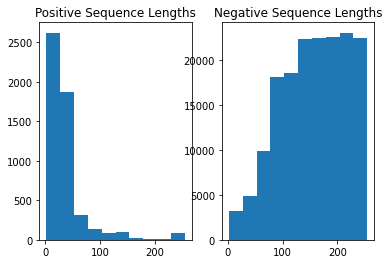

In [17]:
#Original dataset

fig, axes = plt.subplots(1,2)
axes[0].hist([len(seq) for seq in positive_examples])
axes[0].set_title('Positive Sequence Lengths')
axes[1].hist([len(seq) for seq in negative_examples])
axes[1].set_title('Negative Sequence Lengths')

Text(0.5, 1.0, 'Negative Sequence Lengths')

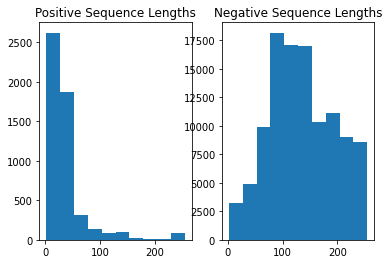

In [18]:
# after removing sequences in Non AMP whose length is not in postivie sample 

fig, axes = plt.subplots(1,2)
axes[0].hist([len(seq) for seq in positive_examples])
axes[0].set_title('Positive Sequence Lengths')
axes[1].hist([len(seq) for seq in negative_examples_new])
axes[1].set_title('Negative Sequence Lengths')

Let's have a look at the data. For example, the first AMP in the dataset is:

In [ ]:
list(positive_examples)[0]

'TKKFPNRRKTAFCSNWNQKIKTV'

This string describes the sequence of [amino acids](https://en.wikipedia.org/wiki/Amino_acid) present in the given AMP. There are $20$ possible such *standard* amino acids present in the genetic code. To know more about the meaning of each of those letter, see [this section](https://en.wikipedia.org/wiki/Amino_acid#Table_of_standard_amino_acid_abbreviations_and_properties) of the Wikipedia page on amino acids.

A non-AMP looks like:

In [ ]:
list(negative_examples)[0]

'MVNYPSGVRAGGYPQKKKNQNIRYGKRGMGLEEMINQANDYYLVNHQAVIHKKPTPITVVHVDYPDRSMAKITEAYYVQPSTTDYNGVVSGKYIDFDAKETKNKTNMPLKNFHQHQITHLKNVLENGGIGFLVLGFTTLSEYYIFPASLLIKIWDKAKAGGEKSLPYKIVSKQGIKINSKMIPSLDYLPALKKLFNI'

In [19]:
import pandas as pd 
df_p=pd.DataFrame(positive_examples,columns=['Sequences'])
df_p['Labels']=1
df_n=pd.DataFrame(negative_examples_new,columns=['Sequences'])
df_n['Labels']=0


In [20]:
print('positive_examples shape is:', df_p.shape)
print('negative_examples shape is:', df_n.shape)

positive_examples shape is: (5264, 2)
negative_examples shape is: (109344, 2)


In [21]:
df=pd.DataFrame()
df=df.append(df_p,ignore_index=True)
df=df.append(df_n,ignore_index=True)
df

,Sequences,Labels
0,RTCENLADKYRGPCFSGCDTHCTTKENAVSGRCRDDFRCWCTKRC,1
1,VFGTLGSTDDSLFGRYKQDIFNDHRGHLQGQAYGSR,1
2,GIFSKKAGKGFKKKSPKAPTPKATKMASECSEPGQALQEKKKR,1
3,RIGSFLGALASKLPTLISWIKNR,1
4,GIHDILKYGKPA,1
...,...,...
114603,MEKCEGIVIRQTSYRESDKIVRMYTREFGKIGVVARGAKKTKSRLA...,0
114604,MDRLVIGGRELKNRLFIGSGKFADERVIRDIVAQTGVEVVTVALRR...,0
114605,MKVKVFDLNGQPVDEIELPRVFLTPFRPDLIRRAVIASWTHRIQPQ...,0
114606,MSTNLHWQSFGQGPDLVLLHGWGMNGAVWQQTVESLQADFCVHVVD...,0


#Data Preprocessing

In [24]:
X_train = df_p['Sequences']
y_train=df_p['Labels'] 

In [29]:
print(np.asarray(X_train))

['RTCENLADKYRGPCFSGCDTHCTTKENAVSGRCRDDFRCWCTKRC'
 'VFGTLGSTDDSLFGRYKQDIFNDHRGHLQGQAYGSR'
 'GIFSKKAGKGFKKKSPKAPTPKATKMASECSEPGQALQEKKKR' ...
 'RICRRRSAGFKGPCVSNKNCAQVCMQEGWGGGNCDGPLRRCKCMRRC' 'GLLSGILGVGKHIVCGLSGLC'
 'GLLSGVLGVGKKVPCGLSGLC']


In [30]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 42)
X_train_new, y_train_new = sm.fit_sample(np.asarray(X_train), np.asarray(y_train))

ValueError: ignored

In [ ]:
! pip install nltk

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
import nltk 
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer() 

# get stop words from nltk
stopWords = stopwords.words('english')

# pre processing data
def cleanData(sentence):
    processedList = ""
    
# Tokenize words
    #sentence=nltk.word_tokenize(sentence)
    sentence=list(sentence)

    
    return sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
cleanData(df['Sequences'][2])

In [ ]:
# clean data 
df['Sequences'] = df['Sequences'].map(lambda x: cleanData(x))

In [ ]:
df['Sequences'] 

0         [F, R, S, G, I, L, K, L, A, S, K, I, P, S, V, ...
1         [G, L, L, N, V, I, K, D, T, A, Q, N, L, F, A, ...
2         [L, I, D, H, L, G, A, P, R, W, A, V, D, T, I, ...
3         [V, K, E, G, I, E, K, A, G, V, C, P, A, D, N, ...
4         [G, L, V, D, V, L, G, K, V, G, G, L, I, K, K, ...
                                ...                        
172991    [M, N, I, V, K, N, E, L, L, Y, E, G, K, A, K, ...
172992    [M, G, L, L, D, N, L, F, G, R, K, Q, Q, N, S, ...
172993    [M, R, I, L, G, I, D, Y, G, D, S, R, I, G, V, ...
172994    [M, R, H, A, K, A, G, R, K, L, N, R, T, A, S, ...
172995    [M, G, N, L, F, V, K, K, P, K, I, T, E, V, D, ...
Name: Sequences, Length: 172996, dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

X=df['Sequences'] 
y=df['Labels'] 

def dummy(doc):
    return doc

vectorizer = TfidfVectorizer(tokenizer=dummy,preprocessor=dummy,lowercase=False)

vectorizer.fit(X)

x_transform = vectorizer.transform(X)

word = vectorizer.get_feature_names()


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [ ]:
x_transform
word

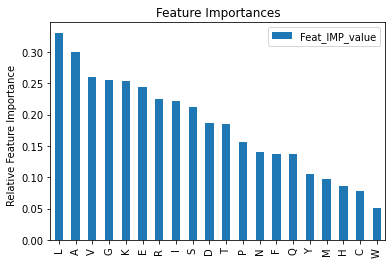

In [ ]:
import numpy as np

TFIDF_mean = np.mean(x_transform, axis=0)

TFIDF_mean 
TFIDF_mean = np.array(TFIDF_mean)[0].tolist()

# Feature_importance=top_feats(TFIDF_mean ,Word, Imp_Feat)

topn_ids = np.argsort(TFIDF_mean)[::-1][:1000]
names = np.array(word)
# print(names[topn_ids])
top_feats = [(word[i], TFIDF_mean[i]) for i in topn_ids]
df_feat = pd.DataFrame(top_feats, index=names[topn_ids])
df_feat.columns = ['FEATURE', 'Feat_IMP_value']

Feature_importance = df_feat
df_feat[:150].plot.bar(y='Feat_IMP_value', title='Feature Importances', rot=90)
plt.ylabel('Relative Feature Importance  ')
New_FI_index = Feature_importance.reset_index()
del New_FI_index['index']
plt.show()
#plt.savefig('feature_Importance.png')

#Train_Test_Split

In [ ]:

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_transform , y,
    stratify=y, 
    test_size=0.2, shuffle=True)

#Intitialisation

In [ ]:
result = pd.DataFrame(columns = ("classifers","Training","Testing"))
classifier, train_scores, test_scores = [],[],[]

#Cross validation 

In [ ]:
#We will decide to go for K fold=5 or LOOCV
k_fold = KFold(n_splits=5, shuffle=True,random_state=1)

#Baselines

##Random Forest Classifier

In [ ]:
rfs = RandomForestClassifier()

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
rfs.fit(X_train,y_train)
y_pred = rfs.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
 max_depth=None, max_features='auto',
                       min_samples_leaf=1, min_samples_split=2, n_estimators=100,
n_estimators=100

0.9811271676300578

###Tune parameters

In [ ]:
#to do Hyper parameter search using Grid search
tuned_parameters = [
  {'n_estimators': [100,500,1000,1500,3500]},
    {'max_features': ['auto', 'sqrt', 'log2']},
      {'max_depth': [None,10,20,30,40,50]},
    {'min_samples_split': [2,5,10,15,20]},
      {'min_samples_leaf': [1,2,5,10,15]},
]

grid_search = GridSearchCV(rfs,tuned_parameters,cv=k_fold,)
grid_search.fit(X_train,y_train);
print('Finished!')

In [ ]:
print("Best parameters set found on development set:")
print()
print(grid_search.best_params_)

In [ ]:
print("Grid scores on development set:")
print()
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

### Final Random forest Model

In [ ]:
# implement with best Hyperparameters and calculate score

In [ ]:
y_pred = rfs.predict(X_test)
print("Test accuracy",rfs.score(X_test, y_test))
print("Train accuracy",rfs.score(X_train, y_train))

classifier.append("RFS")
train_scores.append(rfs.score(X_train, y_train))
test_scores.append(rfs.score(X_test, y_test))

Test accuracy 0.9811271676300578
Train accuracy 0.9958163530737882


##SVM classifier

In [ ]:
#SVM
svc=SVC(random_state=0, tol=1e-5)


In [ ]:
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
accuracy_score(y_test, y_pred)

0.983728323699422

###Tune parameters

In [ ]:
#to do Hyper parameter search using Grid search

tuned_parameters = [  {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'gamma': np.logspace(-1, -2, num=50),
                           'C': np.logspace(0, 3, num=50)}]

grid_search = GridSearchCV(svc,tuned_parameters,cv=k_fold,)
grid_search.fit(X_train,y_train);
print('Finished!')                          

In [ ]:
print("Best parameters set found on development set:")
print()
print(grid_search.best_params_)

In [ ]:
print("Grid scores on development set:")
print()
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

### Final SVC Model

In [ ]:
# implement with best Hyperparameters and calculate score

In [ ]:
y_pred = svc.predict(X_test)
print("Test accuracy",svc.score(X_test, y_test))
print("Train accuracy",svc.score(X_train, y_train))

classifier.append("SVC")
train_scores.append(svc.score(X_train, y_train))
test_scores.append(svc.score(X_test, y_test))

Test accuracy 0.983728323699422
Train accuracy 0.9865747564958525


##Neural Network

In [ ]:
#implement

from sklearn.neural_network import MLPClassifier

Nnw=MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1)#Adam
Nnw.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

###Tune parameters

In [ ]:
#to do Hyper parameter search using Grid search

### Final Neural Network Model

In [ ]:
# implement with best Hyperparameters and calculate score

In [ ]:
y_pred = Nnw.predict(X_test)
print("Test accuracy",Nnw.score(X_test, y_test))
print("Train accuracy",Nnw.score(X_train, y_train))

classifier.append("NNW")
train_scores.append(Nnw.score(X_train, y_train))
test_scores.append(Nnw.score(X_test, y_test))

Test accuracy 0.9803468208092485
Train accuracy 0.9808592733894043


# Improvements : Ensemble method with Crossvalidation

In [ ]:
##### Trying to improve with the ensemble of all predictors
from sklearn.ensemble import VotingRegressor

Reg_vote = VotingRegressor(
    estimators=[
        ('rfs', rfs), # Random Forest
        ('svc', svc), # SVC
        ('Nn', Nnw), # Neural Network
          ])
Reg_vote.fit(X_train, y_train)
Reg_vote.score(X_val, y_val)

In [ ]:
scores = cross_val_score(Reg_vote, X_train, y_train, cv=k_fold)
print("Reg: Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))